# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [ ]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers
%pip install --upgrade yfinance

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf
import time
from time import sleep

## Get the list of stocks in the S&P 500

In [ ]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [ ]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks
# and the value is the output news from the yfinance library

# YOUR CODE HERE

# Add a delay between requests (in seconds)
DELAY = 0.24

all_news = {}

for ticker in ticker_list:
    stock = yf.Ticker(ticker)
    news = stock.news
    all_news[ticker] = news

    time.sleep(DELAY)

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

news_data = []

for ticker, news_list in all_news.items():
    if news_list:
        for article in news_list:
            content = article.get('content')
            if content:
                news_data.append({
                    'TICKER': ticker,
                    'TITLE': content.get('title'),
                    'SUMMARY': content.get('summary'),
                    'PUBLICATION_DATE': content.get('pubDate'),
                    'URL': content.get('canonicalUrl', {}).get('url')
                })

news_df = pd.DataFrame(news_data)
display(news_df.head())
len(news_df)



,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...
1,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,The Dow Jones Industrial Average fell Friday f...,2025-07-18T21:11:10Z,https://finance.yahoo.com/news/dow-falls-trump...


5006

## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- You should combine the title and summary into one string that you will embed together
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

from google.colab import userdata
from huggingface_hub import login
login(userdata.get('miHuggingFace'))

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
texts_to_embed = (
    news_df['TITLE'].fillna('') + '. ' + news_df['SUMMARY'].fillna('')
).tolist()
display(texts_to_embed[:5])

['Zacks Industry Outlook Highlights Honeywell, 3M, Carlisle Companies and Federal Signal. HON, MMM, CSL, and FSS are well-positioned to benefit from defense, aviation, and infrastructure tailwinds despite manufacturing headwinds.',
 'Stock Market News for Jul 21, 2025. U.S. stock markets closed mostly lower n Friday following trade and tariff related concerns.',
 '3M Co (MMM) Q2 2025 Earnings Call Highlights: Strong EPS Growth Amidst Global Challenges. 3M Co (MMM) reports a 12% increase in adjusted EPS and robust shareholder returns, despite facing macroeconomic and legal hurdles.',
 'MMM Q1 Deep Dive: Tariffs Loom Over Stable Operations and Product Launch Momentum. Industrial conglomerate 3M (NYSE:MMM) reported Q2 CY2025 results exceeding the market’s revenue expectations, but sales fell by 1.6% year on year to $6.16 billion. Its non-GAAP profit of $2.16 per share was 7.4% above analysts’ consensus estimates.',
 'Dow Falls as Trump Reportedly Seeks Higher EU Tariffs; Nasdaq Clinches N

In [ ]:
news_df['EMBEDDED_TEXT'] = news_df['TITLE']
display(news_df[['TICKER', 'EMBEDDED_TEXT']].head())

,TICKER,EMBEDDED_TEXT
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3..."
1,MMM,"Stock Market News for Jul 21, 2025"
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...


In [ ]:
embeddings = model.encode(news_df['EMBEDDED_TEXT'], show_progress_bar=True)
news_df['EMBEDDINGS'] = embeddings.tolist()
display(news_df[['EMBEDDED_TEXT', 'EMBEDDINGS']].head())

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

,EMBEDDED_TEXT,EMBEDDINGS
0,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629272028803825, -0.07978320866823196, ..."
1,"Stock Market News for Jul 21, 2025","[-0.037469591945409775, -0.04381367936730385, ..."
2,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080150932073593, -0.029800770804286003, ..."
3,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.019502604380249977, -0.07280390709638596, ..."
4,Dow Falls as Trump Reportedly Seeks Higher EU ...,"[0.018626131117343903, -0.03162861987948418, 0..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [ ]:
news_df = news_df[[
    'TICKER', 'TITLE', 'SUMMARY', 'PUBLICATION_DATE', 'URL',
    'EMBEDDED_TEXT', 'EMBEDDINGS'
]]
news_df = news_df.drop_duplicates(subset='TICKER', keep='first').reset_index(drop=True)
if len(news_df) > 500:
    news_df = news_df.iloc[:500].reset_index(drop=True)
display(news_df.head())
len(news_df)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629272028803825, -0.07978320866823196, ..."
1,AOS,A. O. Smith Set to Report Q2 Earnings: Is a Be...,"AOS eyes an earnings beat in Q2 2025, backed b...",2025-07-21T15:51:00Z,https://finance.yahoo.com/news/o-smith-set-rep...,A. O. Smith Set to Report Q2 Earnings: Is a Be...,"[-0.07036784291267395, 0.033710379153490067, -..."
2,ABT,Tenet Beats Q2 Earnings on Strong Patient Volu...,THC's Q2 earnings benefit on the back of stron...,2025-07-22T17:30:00Z,https://finance.yahoo.com/news/tenet-beats-q2-...,Tenet Beats Q2 Earnings on Strong Patient Volu...,"[-0.030719196423888206, -0.022434629499912262,..."
3,ABBV,AbbVie (ABBV) Outperforms Broader Market: What...,AbbVie (ABBV) reached $187.12 at the closing o...,2025-07-22T21:45:05Z,https://finance.yahoo.com/news/abbvie-abbv-out...,AbbVie (ABBV) Outperforms Broader Market: What...,"[0.019134268164634705, -0.14805561304092407, -..."
4,ACN,Interpublic Group Earnings Beat Estimates in Q...,IPG posts 23% y/y EPS growth in second-quarter...,2025-07-22T16:17:00Z,https://finance.yahoo.com/news/interpublic-gro...,Interpublic Group Earnings Beat Estimates in Q...,"[-0.022264303639531136, 0.007868072018027306, ..."


500

### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

X = np.array(news_df['EMBEDDINGS'].tolist())

silhouette_scores = []
k_values = range(2, 6)
pca_clusters = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    pca_clusters[k] = labels
    print(f"k = {k}, silhouette score = {score:.4f}")

k = 2, silhouette score = 0.0370
k = 3, silhouette score = 0.0431
k = 4, silhouette score = 0.0239
k = 5, silhouette score = 0.0259


#### Plot silhouette scores

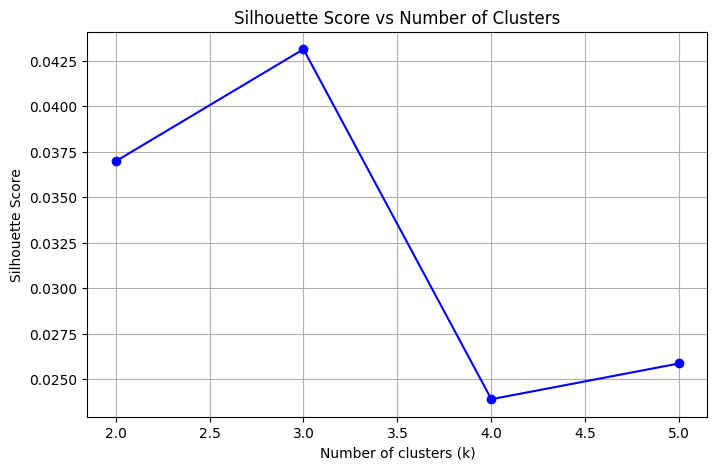

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

#### Identify the Best k

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

best_index = np.argmax(silhouette_scores)
best_k = k_values[best_index]
display(best_k)

3

#### Cluster the embeddings using 3 clusters (k=3)

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

news_df['CLUSTER'] = labels

display(news_df[['TICKER', 'TITLE', 'CLUSTER']].head())

,TICKER,TITLE,CLUSTER
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...",1
1,AOS,A. O. Smith Set to Report Q2 Earnings: Is a Be...,0
2,ABT,Tenet Beats Q2 Earnings on Strong Patient Volu...,0
3,ABBV,AbbVie (ABBV) Outperforms Broader Market: What...,1
4,ACN,Interpublic Group Earnings Beat Estimates in Q...,0


### Visualize the 2 first PCA Components of your embeddings

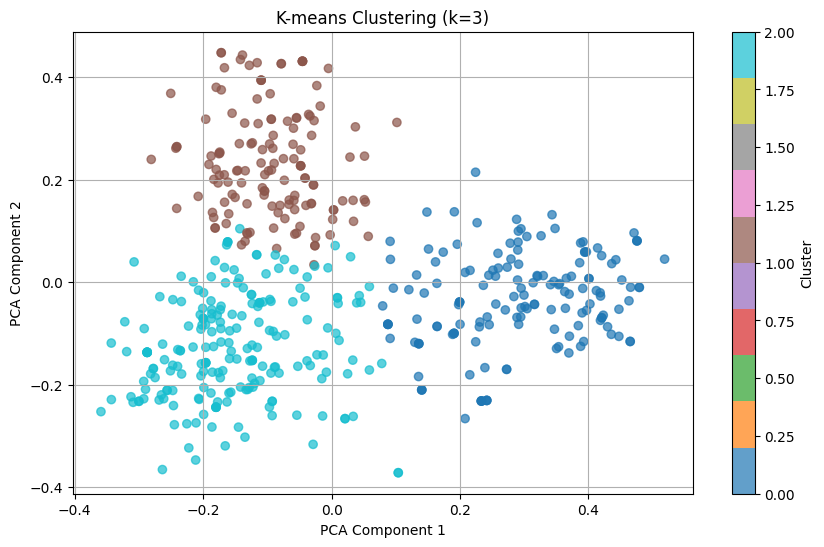

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

pca = PCA(n_components=2, random_state=42)
X_PCA = pca.fit_transform(X)

news_df['PCA1'] = X_PCA[:, 0]
news_df['PCA2'] = X_PCA[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(news_df['PCA1'], news_df['PCA2'],
                      c=news_df['CLUSTER'], cmap='tab10', alpha=0.7)

plt.title('K-means Clustering (k=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [ ]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS


for cluster_id in sorted(news_df['CLUSTER'].unique()):
    print(f"\nCluster {cluster_id+1} ({(news_df['CLUSTER'] == cluster_id).sum()} elements):")
    cluster_df = news_df[news_df['CLUSTER'] == cluster_id]
    display(cluster_df.head(5))



Cluster 1 (154 elements):


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER,PCA1,PCA2
1,AOS,A. O. Smith Set to Report Q2 Earnings: Is a Be...,"AOS eyes an earnings beat in Q2 2025, backed b...",2025-07-21T15:51:00Z,https://finance.yahoo.com/news/o-smith-set-rep...,A. O. Smith Set to Report Q2 Earnings: Is a Be...,"[-0.07036784291267395, 0.033710379153490067, -...",0,0.347085,-0.091686
2,ABT,Tenet Beats Q2 Earnings on Strong Patient Volu...,THC's Q2 earnings benefit on the back of stron...,2025-07-22T17:30:00Z,https://finance.yahoo.com/news/tenet-beats-q2-...,Tenet Beats Q2 Earnings on Strong Patient Volu...,"[-0.030719196423888206, -0.022434629499912262,...",0,0.373475,0.011467
4,ACN,Interpublic Group Earnings Beat Estimates in Q...,IPG posts 23% y/y EPS growth in second-quarter...,2025-07-22T16:17:00Z,https://finance.yahoo.com/news/interpublic-gro...,Interpublic Group Earnings Beat Estimates in Q...,"[-0.022264303639531136, 0.007868072018027306, ...",0,0.479200,-0.010116
6,AMD,General Motors and Coca-Cola earnings reveal a...,It's time for earnings to take the lead story ...,2025-07-22T19:43:13Z,https://finance.yahoo.com/news/general-motors-...,General Motors and Coca-Cola earnings reveal a...,"[-0.07769738882780075, -0.02367793209850788, 0...",0,0.087681,-0.082158
7,AES,AES Corporation’s Q2 2025 Earnings: What to Ex...,AES Corporation is gearing up to report its fi...,2025-07-22T09:56:20Z,https://www.barchart.com/story/news/33548248/a...,AES Corporation’s Q2 2025 Earnings: What to Ex...,"[-0.054363641887903214, 0.031170004978775978, ...",0,0.397032,-0.054958



Cluster 2 (137 elements):


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER,PCA1,PCA2
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629272028803825, -0.07978320866823196, ...",1,-0.066385,0.151801
3,ABBV,AbbVie (ABBV) Outperforms Broader Market: What...,AbbVie (ABBV) reached $187.12 at the closing o...,2025-07-22T21:45:05Z,https://finance.yahoo.com/news/abbvie-abbv-out...,AbbVie (ABBV) Outperforms Broader Market: What...,"[0.019134268164634705, -0.14805561304092407, -...",1,-0.024951,0.086932
9,A,Agilent CFO Bob McMahon resigns,"Rodney Gonsalves, corporate controller and pri...",2025-07-17T14:42:31Z,https://www.medtechdive.com/news/Agilent-CFO-B...,Agilent CFO Bob McMahon resigns,"[0.043878648430109024, 0.00909479707479477, 0....",1,-0.143690,0.270087
21,MO,The FDA Just Approved Juul’s E-Cigarettes. Doe...,Altria was an earlier investor in Juul. Will i...,2025-07-22T19:00:17Z,https://www.barchart.com/story/news/33565345/t...,The FDA Just Approved Juul’s E-Cigarettes. Doe...,"[0.04310077056288719, 0.02759099192917347, 0.0...",1,-0.160180,0.133329
25,AEP,American Electric Power Company (AEP) Declares...,American Electric Power Company (AEP) recently...,2025-07-22T17:19:38Z,https://finance.yahoo.com/news/american-electr...,American Electric Power Company (AEP) Declares...,"[-0.07810061424970627, 0.02046944759786129, 0....",1,0.034188,0.118668



Cluster 3 (209 elements):


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER,PCA1,PCA2
5,ADBE,Figma’s Auction-Like IPO Set Up to Capitalize ...,(Bloomberg) -- Figma Inc. is running its IPO m...,2025-07-22T20:30:44Z,https://finance.yahoo.com/news/figma-auction-i...,Figma’s Auction-Like IPO Set Up to Capitalize ...,"[-0.014775395393371582, 0.0061119841411709785,...",2,-0.161858,0.078339
8,AFL,Do Options Traders Know Something About Aflac ...,Investors need to pay close attention to AFL s...,2025-07-22T15:18:00Z,https://finance.yahoo.com/news/options-traders...,Do Options Traders Know Something About Aflac ...,"[0.024632159620523453, -0.02429807558655739, -...",2,-0.187374,0.010550
11,ABNB,Figma’s Auction-Like IPO Set Up to Capitalize ...,(Bloomberg) -- Figma Inc. is running its IPO m...,2025-07-22T20:30:44Z,https://finance.yahoo.com/news/figma-auction-i...,Figma’s Auction-Like IPO Set Up to Capitalize ...,"[-0.014775422401726246, 0.006111979950219393, ...",2,-0.161858,0.078339
13,ALB,Albemarle Corporation (ALB) is Attracting Inve...,Albemarle (ALB) has been one of the stocks mos...,2025-07-22T13:00:03Z,https://finance.yahoo.com/news/albemarle-corpo...,Albemarle Corporation (ALB) is Attracting Inve...,"[0.0333171971142292, -0.09439100325107574, -0....",2,-0.113183,-0.078297
15,ALGN,Why Align Technology (ALGN) is a Top Momentum ...,The Zacks Style Scores offers investors a way ...,2025-07-18T13:50:01Z,https://finance.yahoo.com/news/why-align-techn...,Why Align Technology (ALGN) is a Top Momentum ...,"[-0.0692296102643013, -0.02913828194141388, 0....",2,-0.274879,-0.185984


## Question section
Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

YOUR WRITTEN RESPONSE HERE

The embedding model affects how well semantic relationships are captured. In this case, MiniLM is lightweight and fast, which is important for scaling to hundreds of tickers. A larger model might produce more detailed and nuanced embeddings, potentially leading to more meaningful clusters. But it also increases runtime and resource use. So it’s a trade-off between efficiency and depth of representation.



#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

YOUR WRITTEN RESONSE HERE

If I used only the TITLE, embeddings would likely capture the main topic in a very condensed form. SUMMARY gives more context, so embeddings might reflect more nuance or sentiment. Combining both gives a fuller picture, which can help clustering be more accurate.

To test it, I’d create three separate columns in the DataFrame: one with only titles, one with only summaries, and one combining both. Then I’d generate embeddings for each, run KMeans separately, and compare silhouette scores and PCA visualizations. Finally, I would show the content of each cluster in every case. This would show which input leads to more meaningful or well-separated clusters.


#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?


YOUR WRITTEN RESPONSE HERE

PCA is fast and good for general trends, but it’s linear. I’d use t-SNE or UMAP if I want to see clearer groupings or patterns that PCA might miss, especially when the clusters are not well separated. They capture more complex structures but take longer to run.


### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.


YOUR WRITTEN RESPONSE HERE

One challenge was that some clusters had mixed topics, making it hard to understand what they really represented. This could be because the embeddings weren’t capturing enough detail. To fix that, I could try using a more powerful embedding model or include more context from the article.

Another issue was deciding how many clusters to use. Even with silhouette scores, the best k wasn’t always clear, and on different days, running the same code gave slightly different results for the best k. That could be due to changes in the news content or randomness in clustering. To address this, I’d not only use silhouette scores, but also manually review sample articles per cluster to see if the groupings actually make sense in context.

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

YOUR WRITTEN RESPONSE HERE

Yes, in the 2D PCA plot I do notice a few potential outliers, especially in areas where a single point is far from the dense core of its cluster. For example, the point around (0.1,-0.375) stands out as it's quite isolated from the rest. These kinds of points don’t really follow the structure of the cluster they were assigned to.

In a production pipeline, I’d identify these outliers using techniques like measuring the distances from the cluster center, or using more sophisticated methods like Local Outlier Factor (LOF) or Isolation Forests. This way, I can identify points that behave differently from the rest of the data. Once detected, I could flag them for review, exclude them from the clustering step to avoid noise, or even group them into a separate category if they consistently fall outside all clusters.

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

YOUR WRITTEN RESPONSE HERE

After reviewing the titles and summaries in each cluster, I would assign the following themes: Cluster 1 seems to focus on upcoming earnings announcements and expectations, with many headlines mentioning companies getting ready to report Q2 results. I’d label this cluster as Earnings Previews, and I’m fairly confident in this label since the titles follow a consistent structure. Cluster 2 appears to cover corporate developments such as resignations, approvals, and broader industry outlooks. This cluster could be labeled Company News & Strategic Moves, though my confidence is moderate since the content is a bit more diverse. Cluster 3 is centered around investment analysis, with articles discussing momentum stocks, IPOs, and trader behavior. I’d label it Investment & Stock Analysis and feel confident in this classification. To validate these assignments more systematically, I could sample several articles from each cluster, analyze the most common keywords, or even apply topic modeling techniques to ensure each group shares consistent underlying themes.

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

YOUR WRITTEN RESPONSE HERE

Incorporating news sentiment could significantly influence the clustering structure by grouping articles not just by topic, but also by tone (positive, negative, or neutral). For example, earnings announcements with optimistic projections might cluster separately from those signaling declines, even if both are about Q2 results. This added dimension would help financial analysts interpret clusters in terms of market sentiment, allowing them to identify not just what the news is about, but how it's likely to impact investor behavior. It could also highlight sectors under stress or momentum, improving decision-making for trading or risk assessment.

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?


YOUR WRITTEN RESPONSE HERE

One key limitation of using k-means for news embeddings is that it assumes clusters are spherical and of similar size, which often doesn’t match the complex structure of text data. It also requires setting the number of clusters in advance, which isn’t always obvious or consistent, as I noticed when different values of k seemed better on different days. K-means is also sensitive to outliers, which can skew cluster centers and affect the overall result.

Alternatives like DBSCAN or HDBSCAN don’t require specifying the number of clusters and can detect clusters of varying shapes and densities, making them more flexible for unstructured data like news. These would be preferable when we expect some articles to not belong to any clear cluster or when noise and outliers are present.

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.


YOUR WRITTEN RESPONSE HERE

To extend the current notebook’s approach and analyze the potential impact of news clusters on stock price movements over time, we could design a high-level pipeline that links news content with market reactions. First, we would retain the clustering step based on news embeddings to group articles into thematic categories. Then, we’d align each news article with its corresponding stock ticker and publication date. For each article, we would retrieve historical stock price data, ideally capturing a short time window around the publication date, such as three days before and after.

Next, we could compute average price changes or returns in that window for each cluster, allowing us to observe whether certain clusters tend to be followed by consistent upward or downward stock movements. To deepen the analysis, we might incorporate sentiment scores as an added feature to evaluate whether sentiment within clusters correlates with market reaction. Finally, we would visualize and interpret the results, comparing how different clusters align with stock behavior.

#### 1️⃣0️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

YOU WRITTEN RESPONSE HERE

Even if clustering shows clear groups of news articles, the lack of improvement in a downstream task like stock movement prediction could happen for several reasons. First, the clusters may reflect differences in writing style, sector, or company focus, but not necessarily in information that moves markets. For example, grouping all earnings reports together doesn’t guarantee that the market reacted the same way to each. Second, financial markets are influenced by many factors beyond news, such as macroeconomic indicators or investor sentiment, so even relevant clusters might not have strong predictive power alone.

Another possibility is a mismatch in timing, as stock prices may not react immediately or may have already priced in the news. Finally, it's possible the target variable is too noisy or too short-term to capture the effect of news, even if the clustering is meaningful. To address this, one could adjust the time window for measuring stock reactions, incorporate sentiment or relevance scoring into the features, or shift toward supervised learning approaches that directly model the relationship between news and stock movement.